In [25]:
%matplotlib inline
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.spm import (OneSampleTTestDesign, EstimateModel,
                                   EstimateContrast, Threshold)
from nipype.interfaces.utility import IdentityInterface
from nipype import Workflow, Node
from nipype.interfaces.fsl import Info
from nipype.algorithms.misc import Gunzip

In [26]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [27]:
experiment_dir = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Which contrasts to use for the 2nd-level analysis
contrast_list = ['con_0001', 'con_0002', 'con_0003', 'con_0004']

# Which task to analyze 
task_list = ['tom']

mask = "/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_brainmask.nii.gz"

In [28]:
# Gunzip - unzip the mask image
gunzip = Node(Gunzip(in_file=mask), name="gunzip")

# OneSampleTTestDesign - creates one sample T-Test Design
onesamplettestdes = Node(OneSampleTTestDesign(),
                         name="onesampttestdes")

# EstimateModel - estimates the model
level2estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level2estimate")

# EstimateContrast - estimates group contrast
level2conestimate = Node(EstimateContrast(group_contrast=True),
                         name="level2conestimate")
cont1 = ['Group', 'T', ['mean'], [1]]
level2conestimate.inputs.contrasts = [cont1]

# Threshold - thresholds contrasts
level2thresh = Node(Threshold(contrast_index=1,
                              use_topo_fdr=True,
                              use_fwe_correction=False,
                              extent_threshold=0,
                              height_threshold=0.005,
                              height_threshold_type='p-value',
                              extent_fdr_p_threshold=0.05),
                    name="level2thresh")

In [29]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['contrast_id', 'fwhm_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('contrast_id', contrast_list),
                        ('fwhm_id', fwhm),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'cons': opj(output_dir, 'antsflow', 'sub-*', 'con', 'task-{task_name}', 'fwhm-{fwhm_id}',
                         '{contrast_id}_trans.nii')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_contrast_id_', '')]
subjFolders = [('%s_fwhm_id_%s' % (con, f), 'spm_%s_fwhm%s' % (con, f))
               for f in fwhm
               for con in contrast_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [30]:
# Initiation of the 2nd-level analysis workflow
l2analysis = Workflow(name='spm_l2analysis')
l2analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 2nd-level analysis components
l2analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (selectfiles, onesamplettestdes, [('cons', 'in_files')]),
                    (gunzip, onesamplettestdes, [('out_file',
                                                  'explicit_mask_file')]),
                    (onesamplettestdes, level2estimate, [('spm_mat_file',
                                                          'spm_mat_file')]),
                    (level2estimate, level2conestimate, [('spm_mat_file',
                                                          'spm_mat_file'),
                                                         ('beta_images',
                                                          'beta_images'),
                                                         ('residual_image',
                                                          'residual_image')]),
                    (level2conestimate, level2thresh, [('spm_mat_file',
                                                        'spm_mat_file'),
                                                       ('spmT_images',
                                                        'stat_image'),
                                                       ]),
                    (level2conestimate, datasink, [('spm_mat_file',
                                                    '2ndLevel.@spm_mat'),
                                                   ('spmT_images',
                                                    '2ndLevel.@T'),
                                                   ('con_images',
                                                    '2ndLevel.@con')]),
                    (level2thresh, datasink, [('thresholded_map',
                                               '2ndLevel.@threshold')]),
                    ])

181008-09:46:13,720 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/spm_l2analysis/graph.png (graph2use=colored, simple_form=True).


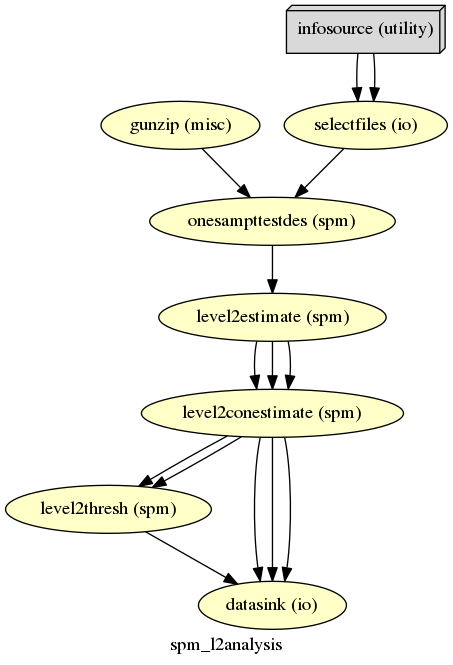

In [31]:
# Create 1st-level analysis output graph
l2analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2analysis.base_dir, 'spm_l2analysis', 'graph.png'))

In [32]:
l2analysis.run('MultiProc', plugin_args={'n_procs': 8})

181008-09:46:14,82 nipype.workflow INFO:
	 Workflow spm_l2analysis settings: ['check', 'execution', 'logging', 'monitoring']
181008-09:46:14,198 nipype.workflow INFO:
	 Running in parallel.
181008-09:46:14,205 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 9 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 8/8.
181008-09:46:14,359 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/data/wellbeing_analysis/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_8_task_name_tom/selectfiles".
181008-09:46:14,362 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/data/wellbeing_analysis/workingdir/spm_l2analysis/_contrast_id_con_0004_fwhm_id_4_task_name_tom/selectfiles".
181008-09:46:14,365 nipype.workflow INFO:
	 [Node] Setting-up "spm_l2analysis.selectfiles" in "/data/wellbeing_analysis/workingdir/spm_l2analysis/_contrast_id_con_0003_fwhm_id_8_task_name_tom/selectfiles".
181008-09:46:14,371 nipype.workflow INFO:
	 [N

RuntimeError: Workflow did not execute cleanly. Check log for details

Process Process-23:
Process Process-18:
Process Process-22:
Process Process-17:
Process Process-19:
Process Process-24:
Process Process-20:
Process Process-21:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/zohyos7/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/zohyos7/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zohyos7/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zohyos7/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/zohyos7/anaconda3/lib/python3.6/multiprocessing/process.py", line 2